### Import Libraries

In [2]:
# Most code adapted from Gabriel Weindel at https://github.com/GWeindel/hmp
# https://github.com/GWeindel/hmp/blob/main/tutorials/sample_data/eeg/0022.ipynb
import mne
import autoreject
import matplotlib.pyplot as plt
import pathlib

### Load information from participant

In [3]:
# Compatibility across PC and laptop where raw data is saved at different locations
data_path = 'D:/thesis/sat1' if pathlib.Path('D:/thesis/sat1').is_dir() else 'C:/thesis/sat1'

# Replace string with subject id
# Loads data_path/eeg4/MD3-{subject_id}.vhdr
subject_id = '00xx'
subject_id_short = subject_id.replace('0', '')

In [58]:
raw = mne.io.read_raw_brainvision(data_path / 'eeg4' / f'MD3-{subject_id}.vhdr', preload=False)
raw.set_channel_types({'EOGh':'eog', 'EOGv':'eog', 'A1':'misc', 'A2':'misc'}) # Declare type to avoid confusion with EEG channels
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'}) # Naming convention
raw.set_montage('standard_1020') # Standard 10-20 electrode montage
raw.rename_channels({'Fp1':'FP1', 'Fp2':'FP2'})
# raw.plot_sensors(ch_type='eeg')

Extracting parameters from D:\thesis\sat1\eeg4\MD3-0022.vhdr...
Setting channel info structure...


C:\Users\Rick\AppData\Local\Temp\ipykernel_8840\3458346569.py:2: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types({'EOGh':'eog', 'EOGv':'eog', 'A1':'misc', 'A2':'misc'}) # Declare type to avoid confusion with EEG channels
C:\Users\Rick\AppData\Local\Temp\ipykernel_8840\3458346569.py:4: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020') # Standard 10-20 electrode montage


<RawBrainVision | MD3-0022.eeg, 34 x 1418896 (2837.8 s), ~52 kB, data not loaded>

Not setting metadata
200 matching events found
No baseline correction applied
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


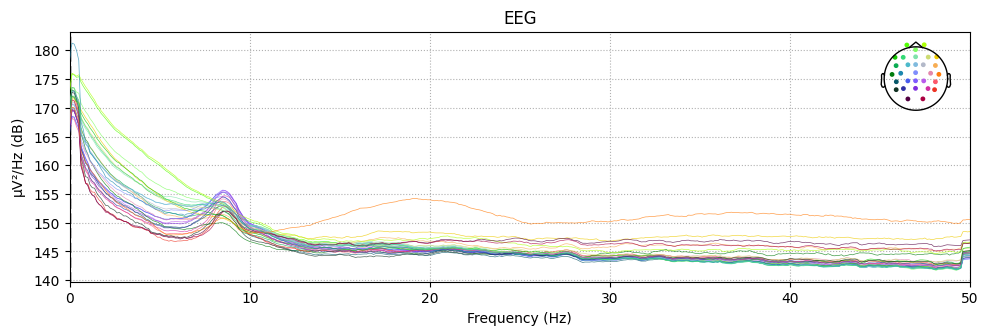

In [59]:
epochs = mne.io.read_epochs_fieldtrip(data_path / 'eeg1' / f'data{subject_id_short}.mat', info=raw.info)
%matplotlib inline
epochs.compute_psd(fmax=50).plot(picks='data', exclude='bads', show=False);

### Filter, crop, baseline resample, and re-reference epochs

In [60]:
epochs.filter(1, 35) # Same bandwidth as van Maanen, Portoles & Borst (2021)
epochs.crop(tmin=-.250)
epochs.resample(100)
epochs.set_eeg_reference('average')
%matplotlib qt
# TODO: Remove manual append
epochs.info["bads"].append('T8')
epochs.plot(block=True, show=False, n_channels=32, scalings=100); # Marking bad electrodes
# Should wait in this cell until popup is closed to prevent errors

Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6000 out of 6000 | elapsed:    2.0s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### Applying ICA

In [61]:
ica = mne.preprocessing.ICA(n_components=30 - len(epochs.info["bads"]) - 1) # -1 for rank deficiency due to average ref
ica.fit(epochs, reject_by_annotation=True)

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by number: 28 components
Fitting ICA took 1.1s.


Method,fastica
Fit,32 iterations on epochs (65000 samples)
ICA components,28
Available PCA components,29
Channel types,eeg
ICA components marked for exclusion,—


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['T8']


In [ ]:
%matplotlib qt
# Reject component by clicking on their label (will gray out)
ica.plot_components(inst=epochs, show=False)

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 8 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


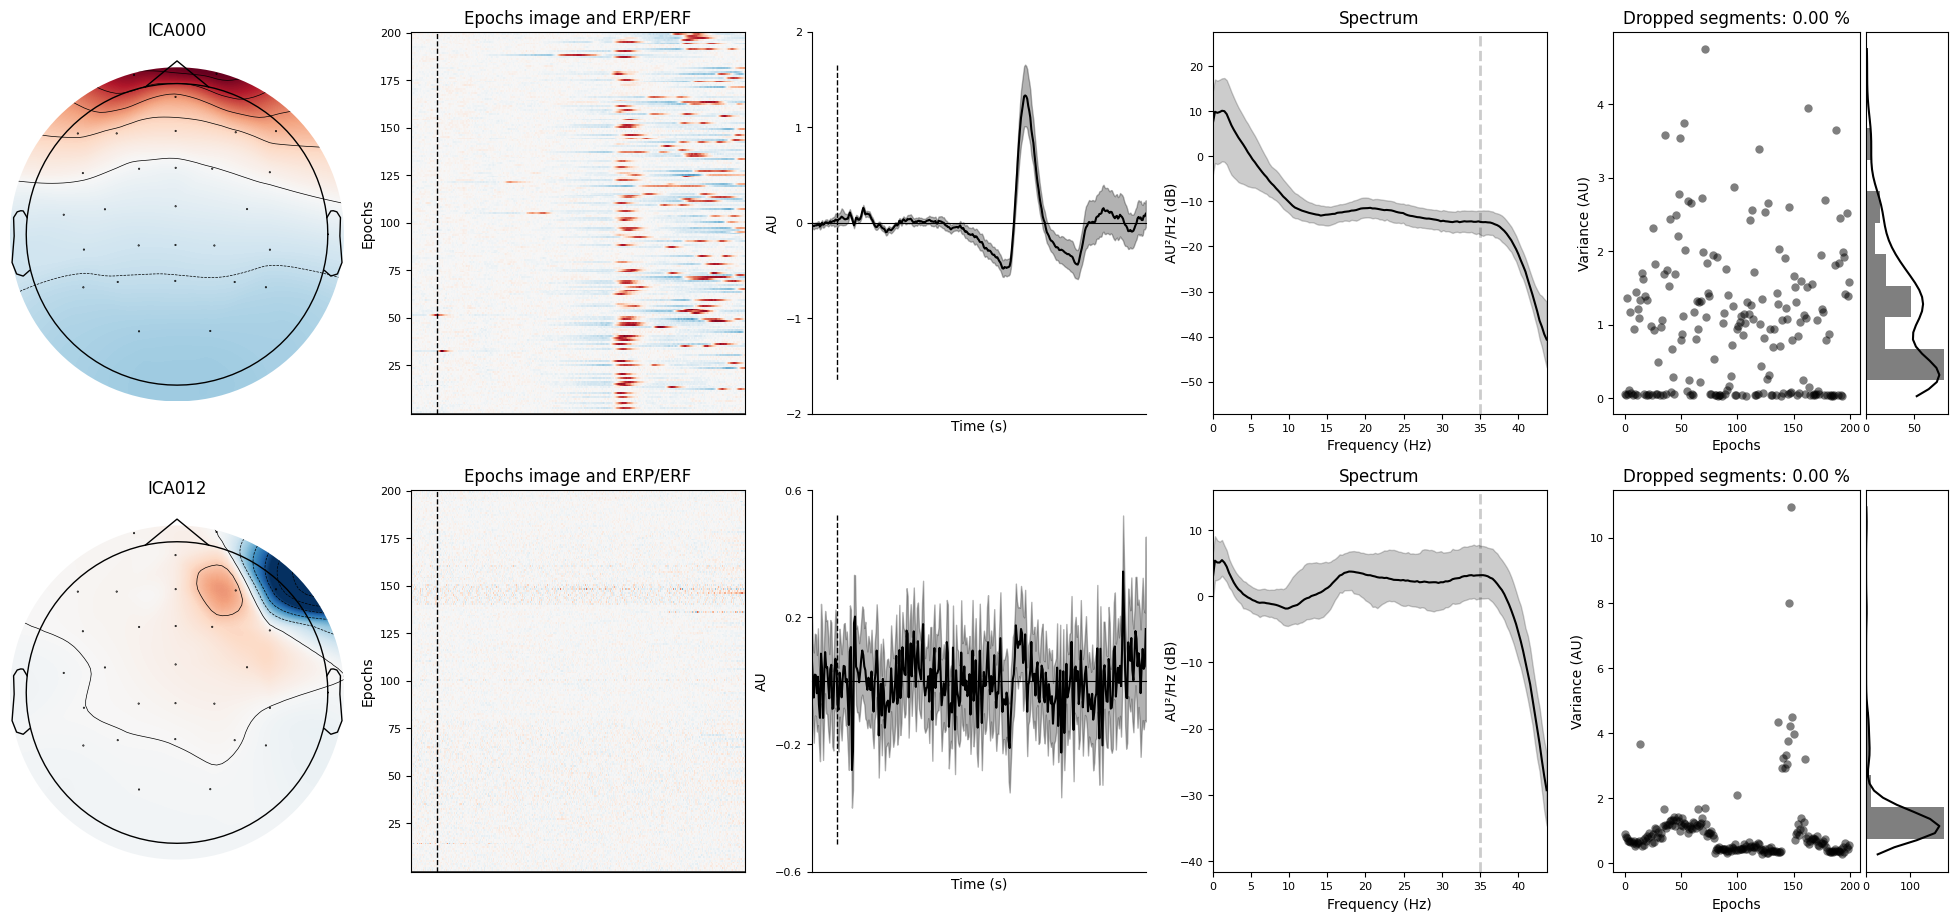

In [63]:
%matplotlib inline 
n_comp = len(ica.exclude)
if n_comp > 0:
    fig, ax = plt.subplots(n_comp, 5, figsize = (25, len(ica.exclude)*5))
    i = 0
    for comp in ica.exclude:
        if n_comp >1:
            ica.plot_properties(epochs, picks=comp, axes=ax[i,:], show=False);
        else:
            ica.plot_properties(epochs, picks=comp, axes=ax[:], show=False);
        i += 1
    plt.show()

### Combining ICA with epoch data

[0, 12]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying ICA to Evoked instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components


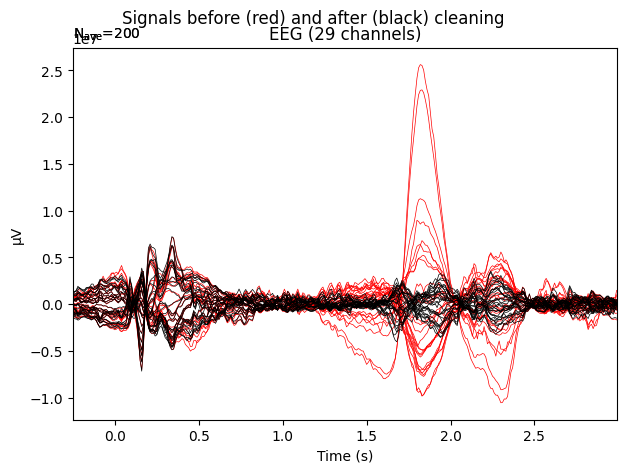

In [64]:
%matplotlib inline
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

In [65]:
ica.apply(epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components


Number of events,200
Events,1: 200
Time range,-0.250 – 2.990 s
Baseline,off


### Interpolate (eventual) bad electrodes

Interpolating bad channels
    Automatic origin fit: head of radius 94.6 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


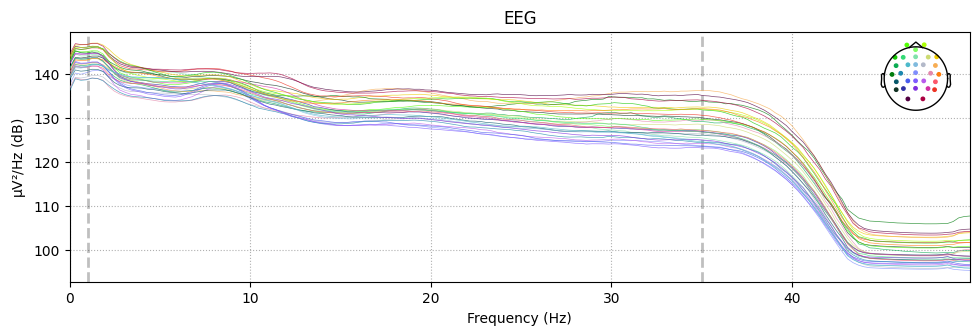

In [66]:
epochs.interpolate_bads()
epochs.pick(['eeg'])
epochs.apply_baseline(baseline=(None, 0))
%matplotlib inline
epochs.compute_psd(fmax=50).plot(picks='data', exclude='bads', show=False);

### Rejecting bad epochs

In [67]:
%matplotlib inline

ar = autoreject.AutoReject(consensus=np.linspace(0, .4, 10), n_interpolate = np.arange(1,round(len(epochs.ch_names)/5)), n_jobs=-1) #I constrain the consensus parameter to be <=.4 as trials with almost half bad chan should be rejected
ar.fit(epochs)  # fit on the first 20 epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.31 and n_interpolate=3


  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

Dropped 16 epochs: 30, 43, 69, 71, 89, 110, 111, 119, 136, 148, 157, 166, 172, 178, 194, 197


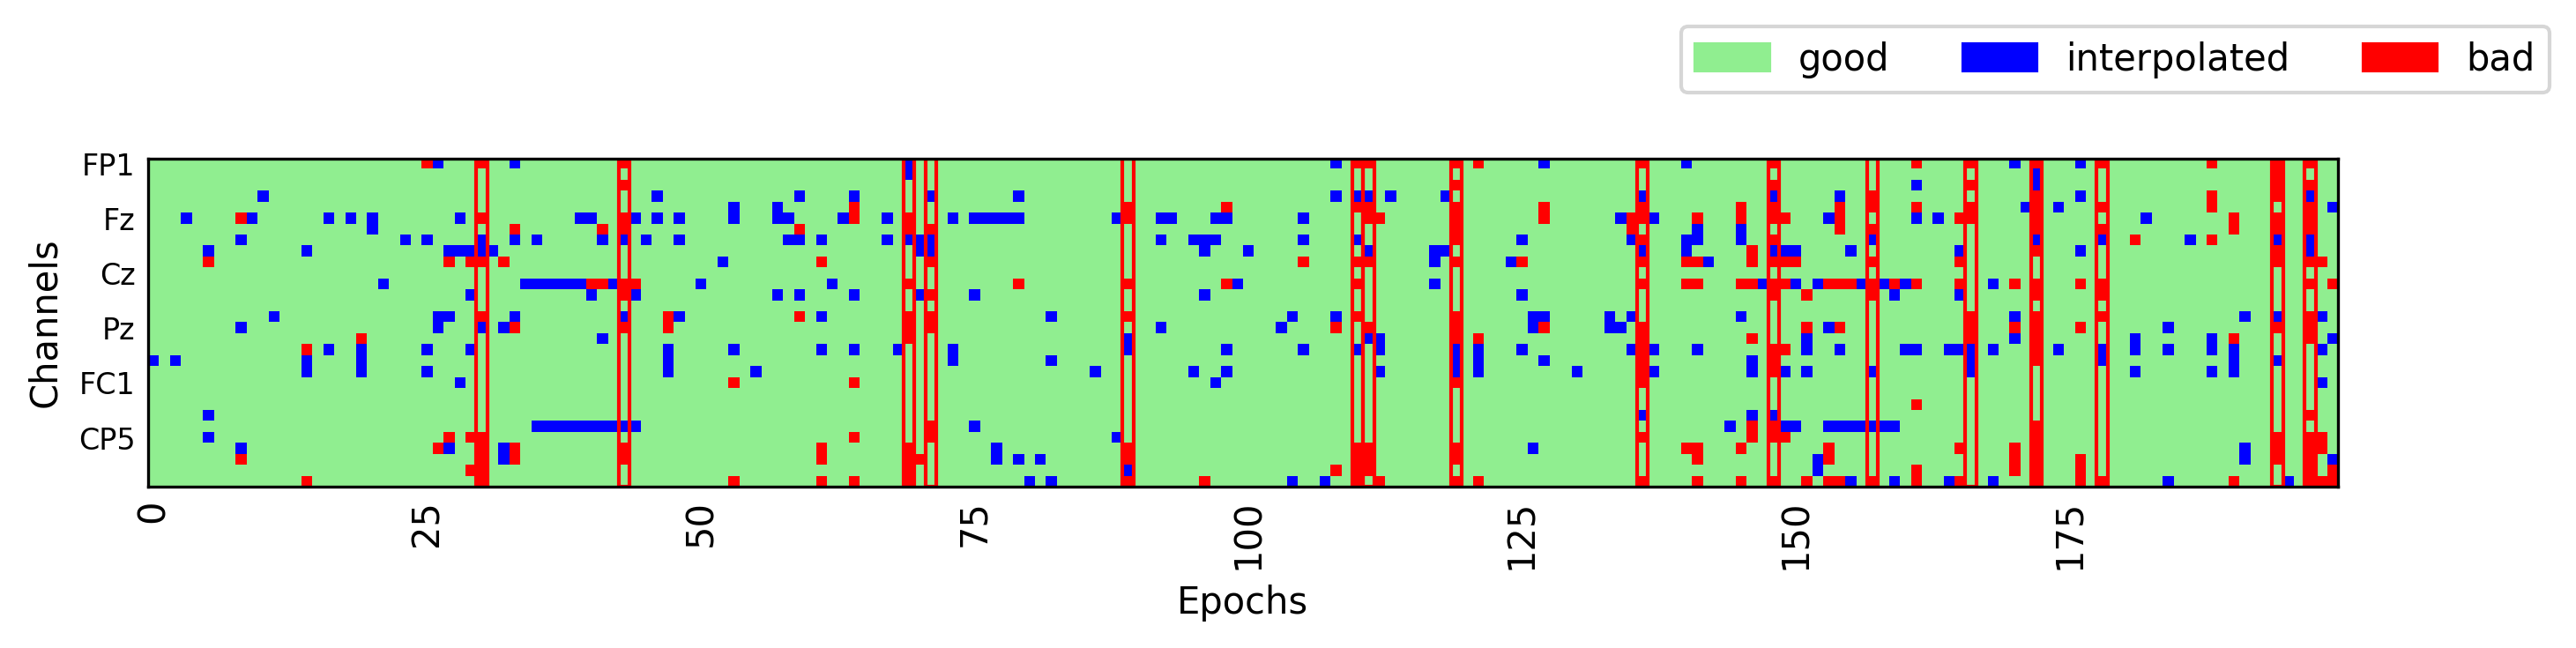

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


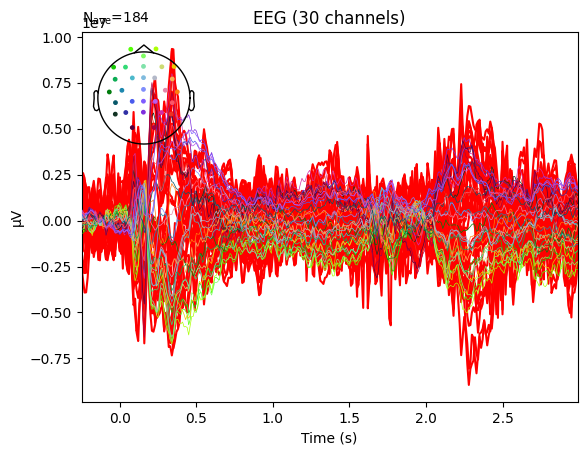

In [68]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,20), dpi=300)
reject_log.plot('horizontal', ax=ax)
plt.show()
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca());

In [69]:
%matplotlib qt
reject_log.plot_epochs(epochs,scalings=dict(eeg=100));

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

Dropped 16 epochs: 30, 43, 69, 71, 89, 110, 111, 119, 136, 148, 157, 166, 172, 178, 194, 197


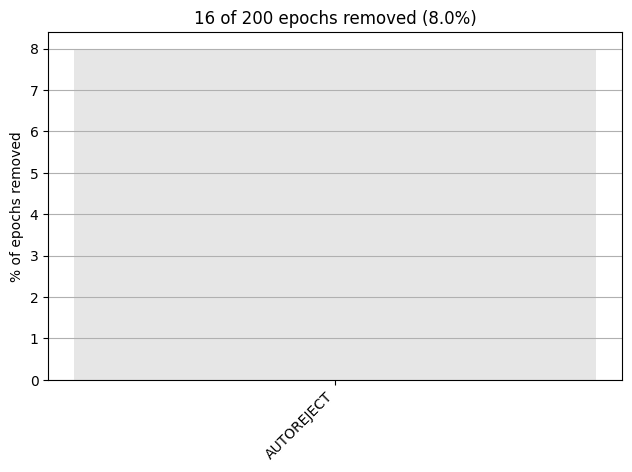

In [70]:
epochs_ar, reject_log = ar.transform(epochs, return_log=True)
%matplotlib inline
epochs_ar.plot_drop_log();

In [71]:
epochs_ar.to_data_frame().to_csv(f'{subject_id}.csv') # Saving CSV
epochs_ar.save(f'{subject_id}_epo.fif', overwrite=True) # Saving EEG mne format

Overwriting existing file.
